# 交配ブースティング

## XGBoost
- 非常に精度が高いアルゴリズム
- GBDTに正則化項を加えることで過学習を防ぐ
  - 木がおおきくなりすぎないようにする
  - １つのモデルで残差を大きく減らさないようにする

In [18]:
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
import numpy as np

In [19]:
df = sns.load_dataset('titanic')
df.dropna(inplace=True)
X = df.loc[:, (df.columns!='survived') & (df.columns!='alive')]
y = df['survived']

cat_cols = X.select_dtypes(exclude=np.number).columns.to_list() # カテゴリカルカラムにのみ処理をするよう、数値カラムをのぞく
oe = OrdinalEncoder()
oe.set_output(transform='pandas')
X[cat_cols] = oe.fit_transform(X[cat_cols])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

/tmp/ipykernel_549/3002474295.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = oe.fit_transform(X[cat_cols])


In [20]:
from xgboost import XGBClassifier

In [21]:
# n_estimators: イテレーションの数
# lerning_rate: パラメータの重み
# eval_metric: early stoppingに使用する評価指標(sklearn.metricsのメソッドを指定)
# early_stopping_rounds: early stopping する際の最低限のイテレーションの回数
# importance_type: デフォルトだろ"weight"（頻度）になっているので"total_dain" を指定する
xgb = XGBClassifier(learnig_rate=0.01,
                    eval_metric='auc',
                    early_stopping_rounds=10,
                    importance='total_gain',
                    random_state=0)
# eval_setにセットするのは検証データをするべき、テストデータを
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

[04:20:22] WARNING: ../src/learner.cc:767: 
Parameters: { "importance", "learnig_rate" } are not used.

[0]	validation_0-auc:0.89904
[1]	validation_0-auc:0.88622
[2]	validation_0-auc:0.87179
[3]	validation_0-auc:0.87740
[4]	validation_0-auc:0.87099
[5]	validation_0-auc:0.86699
[6]	validation_0-auc:0.86538
[7]	validation_0-auc:0.86218
[8]	validation_0-auc:0.85897
[9]	validation_0-auc:0.85978


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None,
              importance='total_gain', importance_type=None,
              interaction_constraints=None, learnig_rate=0.01,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [22]:
from sklearn.metrics import roc_auc_score
y_pred_xgb = xgb.predict_proba(X_test)
print(f"xgboots AUC: {roc_auc_score(y_test, y_pred_xgb[:, 1])}")

xgboots AUC: 0.8990384615384616


In [23]:
xgb.feature_importances_

array([0.        , 0.        , 0.05132714, 0.02888336, 0.02025795,
       0.05180834, 0.        , 0.        , 0.19185798, 0.5812387 ,
       0.05139798, 0.        , 0.02322854], dtype=float32)

<AxesSubplot:>

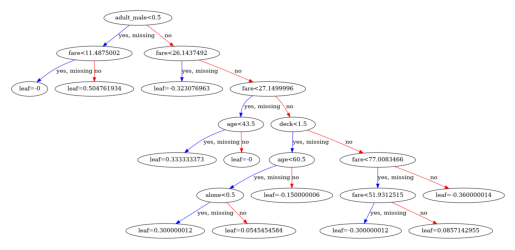

In [24]:
import xgboost
xgboost.plot_tree(xgb, num_trees=0)

## LightGBM
- XGBoost同様、勾配ブースティング決定木のアルゴリズム
- XGboostよりも高速で精度が高くなることがおおい
    - leaf wise（bset first） で決定木を作ることで高速化(最も損失が少なるよなノードから分割していくやり方)  
        - level wise: 左のノードから順に分割し、その階層の分割が全て終わったら次の階層に行くように決定木を構築していく -> leaf wise　の方がよい
    - histogram basedで決定木のノードを分割することで高速化
        - データをヒストグラム化し、bin単位で分割することで高速化をする。いくつかの値をbinにして、bin毎で分割した時の損失を計算し最良点で分割
    - Gradient-based One-Side Sampling(GOSS)で学習データを減らし高速化
        - 残差が小さいデータ（うまく学習ができているデータ）の一部を学習に使わないことで高速化する
    - Exclusive Feature Bundling(EFB)で特徴量を減らし高速化
        - 互いに排他的な複数の特徴量を1つにまとめる
        - one-hot-vectorは互いに排他的
        - 特徴量が多い場合は、欠損値が多いスカスカなデータであることが多い
        - 衝突が少ない特徴量同士をbundle化する
        - それぞれの特徴量の値の範囲が被らないようにずらす

In [25]:
import lightgbm as lgb

In [26]:
df = sns.load_dataset('titanic')
df.dropna(inplace=True)
X = df.loc[:, (df.columns!='survived') & (df.columns!='alive')]
y = df['survived']

oe = OrdinalEncoder()
oe.set_output(transform='pandas')
X = oe.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [30]:
lgbmc = lgb.LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)
# early stoppingに使用する検証データ.実際のデータではテストデータは未知のデータになっているのでバリデーションデータ（検証用データ）をいれること。たとえばkfoldをしてみたりすることが大切
eval_set=[(X_test, y_test)]
# イテレーション時に実施(callback)する関数
# 最低限10回す
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=10))
callbacks.append(lgb.log_evaluation())
# 学習
lgbmc.fit(X_train, y_train, eval_set=eval_set, callbacks=callbacks)


[1]	valid_0's binary_logloss: 0.56902
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.536293
[3]	valid_0's binary_logloss: 0.50876
[4]	valid_0's binary_logloss: 0.485108
[5]	valid_0's binary_logloss: 0.464864
[6]	valid_0's binary_logloss: 0.447251
[7]	valid_0's binary_logloss: 0.433086
[8]	valid_0's binary_logloss: 0.41859
[9]	valid_0's binary_logloss: 0.408127
[10]	valid_0's binary_logloss: 0.400311
[11]	valid_0's binary_logloss: 0.400311
[12]	valid_0's binary_logloss: 0.400311
[13]	valid_0's binary_logloss: 0.400311
[14]	valid_0's binary_logloss: 0.400311
[15]	valid_0's binary_logloss: 0.400311
[16]	valid_0's binary_logloss: 0.400311
[17]	valid_0's binary_logloss: 0.400311
[18]	valid_0's binary_logloss: 0.400311
[19]	valid_0's binary_logloss: 0.400311
[20]	valid_0's binary_logloss: 0.400311
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.400311


LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)

In [31]:
y_pred_lgbmc = lgbmc.predict_proba(X_test)
print(f"light gbm AUC: {roc_auc_score(y_test, y_pred_lgbmc[:, 1])}")

light gbm AUC: 0.9383012820512822


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

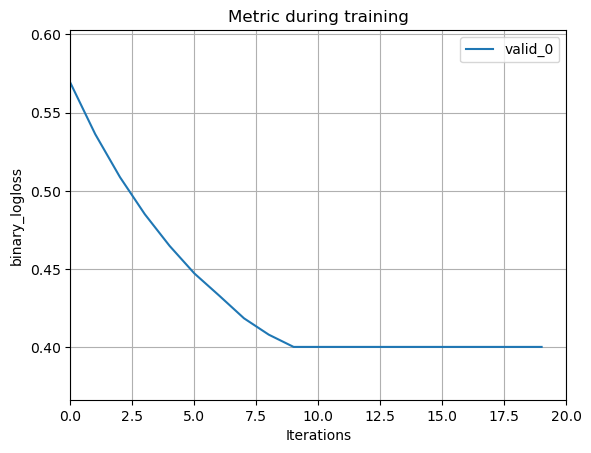

In [32]:
# 学習曲線
lgb.plot_metric(lgbmc)

<AxesSubplot:>

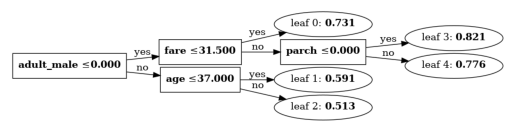

In [33]:
lgb.plot_tree(lgbmc, tree_index=0)

## catbooost
- 勾配ブースティング決定木のアルゴリズムの1つ
- XGboostやLightGBMより後発で使い勝手がよく高精度が期待できる
- 開発者曰くXGBoostやLightGBMよりもいいとされる
- カテゴリカル変数の扱いー＞前処理が不要
    - One-hot-encoding　
        - 決定木では悪手
        - 計算量の増加＆決定木が複雑になる
    - Target encoding (これが使われる)
        - 各カテゴリ毎のtargetの統計量(TS{target statictics})で代替
        - 過学習しやすい
        - target leakage(テストデータの target：目的変数　を使うことが過学習につながる。なので、kfoldなどを使って処理する必要あり)
    - ordered ts
    - 過去のデータからtsを算出する
        - 実際には時系列ではないのでランダムに順序を決める
        - one-hot encodningに比べ、データが圧縮される
- 決定木の値の計算ー＞過学習を防ぐ
- ordered boosting
    - 従来の勾配ブースティングは勾配の推定で過学習気味になる
        - 勾配の推定で、そのデータを使って学習した学種器を使うので実際の分布とズレる
    - 残差の計算に使うモデルを推論に使うモデル群と分ける
        - 1つ前までのデータを使って学習する
        - これにより過学習を避ける
- Symmetric Trees 
    - 同じ階層では全てのノードで同じ特徴量の同じ条件で分割をする
    - 全てのデータに対して共通の処理を行えるので効率がよい
    - 特に推論の高速化が期待できる

In [38]:
df = sns.load_dataset('titanic')
df.dropna(inplace=True)
X = df.loc[:, (df.columns!='survived') & (df.columns!='alive')]
y = df['survived']
cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()

# oe = OrdinalEncoder()
# oe.set_output(transform='pandas')
# X = oe.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [39]:
cbc = CatBoostClassifier(iterations=1000, learning_rate=0.01, cat_features=cat_cols)
eval_set = [(X_test, y_test)]
cbc.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=10, verbose=True)

0:	learn: 0.6885366	test: 0.6868442	best: 0.6868442 (0)	total: 18.1ms	remaining: 18.1s
1:	learn: 0.6814490	test: 0.6793775	best: 0.6793775 (1)	total: 26.4ms	remaining: 13.2s
2:	learn: 0.6760508	test: 0.6726860	best: 0.6726860 (2)	total: 29.8ms	remaining: 9.92s
3:	learn: 0.6712676	test: 0.6671826	best: 0.6671826 (3)	total: 32.5ms	remaining: 8.1s
4:	learn: 0.6653107	test: 0.6593995	best: 0.6593995 (4)	total: 34.7ms	remaining: 6.9s
5:	learn: 0.6598695	test: 0.6518437	best: 0.6518437 (5)	total: 37ms	remaining: 6.13s
6:	learn: 0.6558456	test: 0.6467404	best: 0.6467404 (6)	total: 39.4ms	remaining: 5.59s
7:	learn: 0.6515199	test: 0.6413944	best: 0.6413944 (7)	total: 42.8ms	remaining: 5.31s
8:	learn: 0.6471426	test: 0.6356173	best: 0.6356173 (8)	total: 47.2ms	remaining: 5.19s
9:	learn: 0.6431772	test: 0.6310513	best: 0.6310513 (9)	total: 52.5ms	remaining: 5.2s
10:	learn: 0.6392733	test: 0.6260433	best: 0.6260433 (10)	total: 56.5ms	remaining: 5.08s
11:	learn: 0.6349835	test: 0.6211657	best: 0.6

In [40]:
y_pred_cbc = cbc.predict_proba(X_test)
print(f"catboost AUC: {roc_auc_score(y_test, y_pred_cbc[:, 1])}")

catboost AUC: 0.8942307692307693


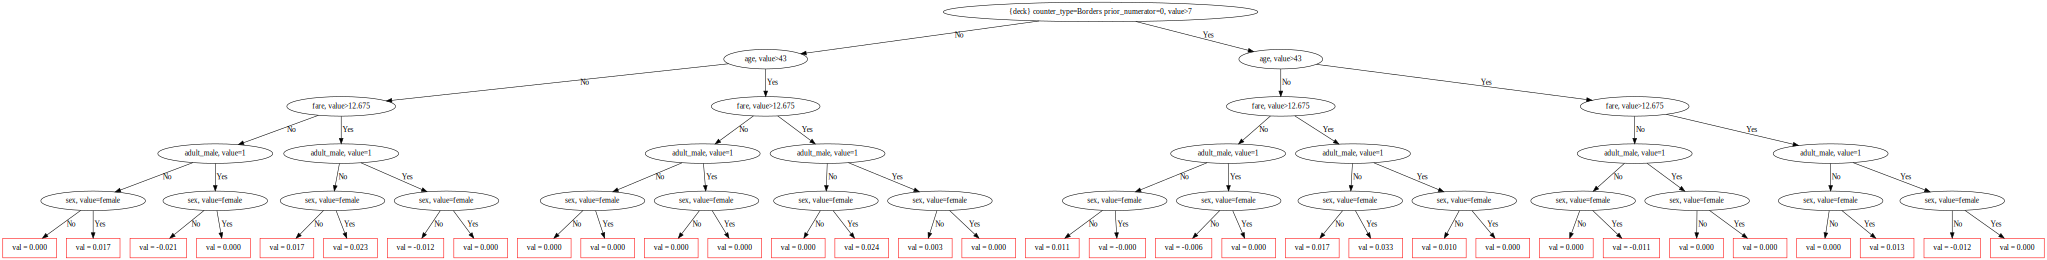

In [41]:
pool = Pool(X_train, y_train, cat_features=cat_cols)
cbc.plot_tree(tree_idx=1, pool=pool)